In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.0
pandas 1.0.5
sklearn 0.23.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# kaggle环境数据
# 下载到本地数据，需要更改如下代码
""" kaggle
train_dir = "/kaggle/input/10-monkey-species/training/training"
valid_dir = "/kaggle/input/10-monkey-species/validation/validation"
label_file = "/kaggle/input/10-monkey-species/monkey_labels.txt"
"""
train_dir = "./10monkeys/10-monkey-species/training/training"
valid_dir = "./10monkeys/10-monkey-species/validation/validation"
label_file = "./10monkeys/10-monkey-species/monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [3]:
labels = pd.read_csv(label_file,header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [4]:
# 做卷积的时候所有图片的尺寸应该是一样的
# 这两个参数是把图片读取进来后缩放到多大
# 卷积神经网络无法预处理大小不一致的图片，所以要对读取的图片进行大小变化
height = 128
width = 128
channels = 3 
batch_size = 64
num_classes = 10
epochs = 10

# 读取训练数据并作数据增强
# 确定一些读取格式要求
# keras.preprocessing.image.ImageDataGenerator
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    # 图片旋转的角度范围，用来数据增强
    rotation_range = 40,
    # 水平平移
    width_shift_range = 0.2,
    # 高度平移
    height_shift_range = 0.2,
    # 剪切强度
    shear_range = 0.2,
    # 缩放强度
    zoom_range = 0.2,
    # 水平翻转
    horizontal_flip = True,
    # 对图片做处理时需要填充图片，用最近的像素点填充
    fill_mode = "nearest"
)
# 读取训练数据
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # 读取后将图片存什么大小 
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    # label的编码格式：这里为one-hot编码
    class_mode = 'categorical')

# 读取验证数据
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    # 读取后将图片存什么大小 
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    # label的编码格式：这里为one-hot编码
    class_mode = 'categorical')

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [5]:
for i in range(2):
    x,y = train_generator.next()
    print(x.shape,y.shape)
    print(y)
    


(64, 128, 128, 3) (64, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [10]:
epochs = 50
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[width,height,channels]),
    keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(pool_size =2),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(num_classes,activation='softmax')
    
])
# 因为y是one-hot 所以 categorical_crossentropy  非 sparse_categorical_crossentropy
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)      

In [11]:
logdir = '10monkeys-cnn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)    
output_model_file = os.path.join(logdir,"10monkeys_cnn_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-8)
]
history = model.fit_generator(train_generator,
                               steps_per_epoch = train_num // batch_size,
                               epochs = epochs,
                               validation_data = valid_generator,
                               validation_steps = valid_num // batch_size,
                               callbacks=callbacks)


Epoch 1/50
17/17 [==============================] - 120s 7s/step - loss: 2.3059 - accuracy: 0.0986 - val_loss: 2.3051 - val_accuracy: 0.0391
Epoch 2/50
17/17 [==============================] - 115s 7s/step - loss: 2.2866 - accuracy: 0.0986 - val_loss: 2.2349 - val_accuracy: 0.1523
Epoch 3/50
17/17 [==============================] - 122s 7s/step - loss: 2.2178 - accuracy: 0.1712 - val_loss: 2.1700 - val_accuracy: 0.1641
Epoch 4/50
17/17 [==============================] - 126s 7s/step - loss: 2.0607 - accuracy: 0.2031 - val_loss: 2.0463 - val_accuracy: 0.2383
Epoch 5/50
17/17 [==============================] - 116s 7s/step - loss: 1.9591 - accuracy: 0.2776 - val_loss: 1.8420 - val_accuracy: 0.3359
Epoch 6/50
17/17 [==============================] - 108s 6s/step - loss: 1.8379 - accuracy: 0.3082 - val_loss: 1.8619 - val_accuracy: 0.3281
Epoch 7/50
17/17 [==============================] - 118s 7s/step - loss: 1.8180 - accuracy: 0.3070 - val_loss: 1.7254 - val_accuracy: 0.3789
Epoch 8/50
17

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

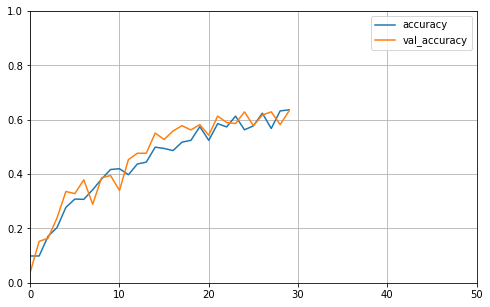

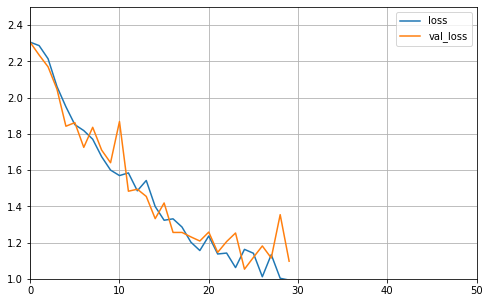

In [13]:
def plot_leraning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_leraning_curves(history, 'accuracy', epochs, 0, 1)
plot_leraning_curves(history, 'loss', epochs, 1.0, 2.5)